In [1]:
import duckdb
import requests
from pathlib import Path
import gzip
import shutil

In [2]:
DATA_DIR = Path("./data") 

In [3]:
aggregate_data = False # @param ["False", "True"] {type:"raw"}

In [4]:
DATA_DIR = Path("../data")

DB_PATH = "ecommerce.duckdb"

# Connect to DuckDB (this creates a persistent file on disk)
con = duckdb.connect(DB_PATH)
if aggregate_data:

    MONTHS = [
    "2019-Oct", "2019-Nov", "2019-Dec",
    "2020-Jan", "2020-Feb", "2020-Mar", "2020-Apr"
    ]

    BASE_URL = "https://data.rees46.com/datasets/marketplace/"
    TMP_DIR = Path("tmp_downloads")
    TMP_DIR.mkdir(exist_ok=True)

    con.execute("DROP TABLE IF EXISTS session_summary")
    con.execute("""
    CREATE TABLE session_summary (
        user_id VARCHAR,
        user_session VARCHAR,
        product_id VARCHAR,
        brand VARCHAR,
        category_id BIGINT,
        category_code VARCHAR,
        price DOUBLE,
        view_time TIMESTAMP,
        added_to_cart BOOLEAN,
        purchased BOOLEAN
    )
    """)

    # Template SQL
    QUERY_TEMPLATE = """
    WITH base AS (
        SELECT *
        FROM '{file_path}'
        WHERE user_id IS NOT NULL AND product_id IS NOT NULL AND user_session IS NOT NULL
    ),
    view_events AS (
        SELECT
            user_id,
            user_session,
            product_id,
            MIN(event_time) AS view_time
        FROM base
        WHERE event_type = 'view'
        GROUP BY user_id, user_session, product_id
    ),
    flags AS (
        SELECT
            user_id,
            user_session,
            product_id,
            MAX(event_type = 'cart')::BOOLEAN AS added_to_cart,
            MAX(event_type = 'purchase')::BOOLEAN AS purchased,
            MAX(brand) AS brand,
            MAX(category_id) AS category_id,
            MAX(category_code) AS category_code,
            MAX(price) AS price
        FROM base
        GROUP BY user_id, user_session, product_id
    )
    SELECT
        f.user_id,
        f.user_session,
        f.product_id,
        f.brand,
        f.category_id,
        f.category_code,
        f.price,
        v.view_time,
        f.added_to_cart,
        f.purchased
    FROM flags f
    LEFT JOIN view_events v
    ON f.user_id = v.user_id AND f.user_session = v.user_session AND f.product_id = v.product_id
    """

    # Main loop
    for month in MONTHS:
        print(f"🔽 Downloading {month}...")
        url = f"{BASE_URL}{month}.csv.gz"
        gz_path = TMP_DIR / f"{month}.csv.gz"

        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(gz_path, 'wb') as f:
                shutil.copyfileobj(r.raw, f)

        print(f"📊 Processing {gz_path.name} into DuckDB without manual decompression...")
        query = QUERY_TEMPLATE.format(file_path=str(gz_path))
        con.execute(f"INSERT INTO session_summary {query}")

        gz_path.unlink()
        print(f"✅ {month} done and cleaned up.\n")

    print("🎉 All months processed. DuckDB file ready: ecommerce.duckdb")


In [5]:
result = con.execute("""
    SELECT *
    FROM session_summary
    WHERE purchased = TRUE
    LIMIT 10
""").df()
result

,user_id,user_session,product_id,brand,category_id,category_code,price,view_time,added_to_cart,purchased
0,554834118,3ccb47f7-1aea-4dc5-ae20-ac602b20737b,1004873,samsung,2053013555631882655,electronics.smartphone,388.81,2019-10-01 04:53:41,True,True
1,554235906,cc754ba3-8df5-44db-b740-bd963e309965,1004250,apple,2053013555631882655,electronics.smartphone,804.21,2019-10-01 04:56:42,False,True
2,543953063,e1dadb4f-d0e5-4ab5-b61b-c6ca8261d4ea,1801690,samsung,2053013554415534427,electronics.video.tv,368.04,2019-10-01 04:56:51,True,True
3,534837825,23543623-0a2e-b4b0-e339-ba30bff051aa,1004767,samsung,2053013555631882655,electronics.smartphone,254.76,2019-10-01 04:59:54,True,True
4,531172496,4ccfd0a1-5aa1-47e4-b2de-8fbcef83390a,1004767,samsung,2053013555631882655,electronics.smartphone,254.76,2019-10-01 05:14:27,True,True
5,512836766,667310e7-b0e7-4b5e-a4a6-770f15f84547,1004836,samsung,2053013555631882655,electronics.smartphone,241.18,2019-10-01 05:23:24,True,True
6,514914742,dfd392f2-1690-4229-91bc-229cc692d3cb,10700827,ubisoft,2053013561277416167,None,48.88,2019-10-01 05:27:02,False,True
7,512403922,d360fb2a-cc4c-4d49-a7c0-4b1fb36b2d7d,1002547,apple,2053013555631882655,electronics.smartphone,470.77,2019-10-01 05:29:34,False,True
8,515037132,c4aaa99c-81e7-4c9f-999b-ebb6b550bea5,4804055,apple,2053013554658804075,electronics.audio.headphone,188.73,2019-10-01 05:29:46,True,True
9,515070788,10deb55f-faf9-4a3a-a9df-ce134704c5ed,26025820,None,2053013562812531517,None,2.45,2019-10-01 05:31:18,False,True


In [6]:
query_top_view_pairs = """
SELECT 
    LEAST(a.category_code, b.category_code) AS cat1,
    GREATEST(a.category_code, b.category_code) AS cat2,
    COUNT(*) AS count
FROM session_summary a
JOIN session_summary b
  ON a.user_session = b.user_session
  AND a.category_code IS NOT NULL
  AND b.category_code IS NOT NULL
  AND a.category_code <> b.category_code
  AND a.product_id < b.product_id
GROUP BY cat1, cat2
ORDER BY count DESC
LIMIT 15
"""
top_view_pairs = con.execute(query_top_view_pairs).fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
top_view_pairs 

,cat1,cat2,count
0,appliances.kitchen.refrigerators,construction.tools.light,5277368
1,construction.tools.light,electronics.smartphone,5160877
2,computers.peripherals.printer,construction.components.faucet,3718100
3,construction.tools.light,electronics.clocks,3640765
4,apparel.shoes.sandals,appliances.kitchen.refrigerators,3496882
5,apparel.shoes,apparel.shoes.keds,3357421
6,computers.notebook,electronics.audio.headphone,3248338
7,construction.tools.light,sport.bicycle,2852870
8,auto.accessories.compressor,computers.peripherals.printer,2591912
9,construction.tools.light,electronics.camera.video,2581338


In [8]:
query_top_purchase_pairs = """
SELECT 
    LEAST(a.category_code, b.category_code) AS cat1,
    GREATEST(a.category_code, b.category_code) AS cat2,
    COUNT(*) AS count
FROM session_summary a
JOIN session_summary b
  ON a.user_session = b.user_session
  AND a.category_code IS NOT NULL
  AND b.category_code IS NOT NULL
  AND a.category_code <> b.category_code
  AND a.product_id < b.product_id
WHERE a.purchased = TRUE AND b.purchased = TRUE 
GROUP BY cat1, cat2
ORDER BY count DESC
LIMIT 15
"""
top_purchase_pairs = con.execute(query_top_purchase_pairs).fetchdf()
top_purchase_pairs

,cat1,cat2,count
0,construction.tools.light,sport.bicycle,17467
1,appliances.personal.massager,construction.tools.light,10706
2,appliances.kitchen.refrigerators,construction.tools.light,10672
3,construction.tools.light,electronics.clocks,9313
4,construction.tools.light,electronics.audio.headphone,8828
5,apparel.shoes,construction.tools.light,8031
6,electronics.audio.headphone,electronics.smartphone,4149
7,construction.tools.light,electronics.smartphone,4021
8,appliances.kitchen.washer,construction.tools.light,3897
9,apparel.shoes.slipons,construction.tools.light,3680


In [9]:
query_purchase_pair_freq = """
WITH purchases AS (
    SELECT
        user_session,
        product_id,
        SPLIT_PART(category_code, '.', 1) AS major_category
    FROM session_summary
    WHERE purchased = TRUE
      AND category_code IS NOT NULL
),

session_products AS (
    SELECT DISTINCT
        user_session,
        major_category,
        product_id
    FROM purchases
),

pairs AS (
    SELECT
        sp1.major_category AS base_category,
        sp1.product_id AS base_product,
        sp2.major_category AS co_category,
        sp2.product_id AS co_product,
        sp1.user_session
    FROM session_products sp1
    JOIN session_products sp2
      ON sp1.user_session = sp2.user_session
     AND (
          sp1.major_category <> sp2.major_category
          OR (sp1.major_category = sp2.major_category AND sp1.product_id <> sp2.product_id)
     )
)

SELECT
    base_category,
    co_category,
    COUNT(DISTINCT user_session) AS co_occurrence_count
FROM pairs
GROUP BY base_category, co_category
ORDER BY base_category, co_occurrence_count DESC;
"""

purchase_pair_freq = con.execute(query_purchase_pair_freq).fetchdf()
purchase_pair_freq

,base_category,co_category,co_occurrence_count
0,accessories,construction,1310
1,accessories,apparel,1310
2,accessories,accessories,1015
3,accessories,appliances,728
4,accessories,electronics,661
...,...,...,...
162,stationery,computers,8
163,stationery,accessories,3
164,stationery,kids,3
165,stationery,auto,2


In [10]:
purchase_pair_freq["base_category"] = purchase_pair_freq["base_category"].apply(lambda x: x.get("unnest") if isinstance(x, dict) else x)
purchase_pair_freq["co_category"] = purchase_pair_freq["co_category"].apply(lambda x: x.get("unnest") if isinstance(x, dict) else x)


purchase_pair_freq_sorted = purchase_pair_freq.sort_values(["base_category", "co_occurrence_count"], ascending=[True, False])
top3_df = purchase_pair_freq_sorted.groupby("base_category").head(3).reset_index(drop=True)

top3_df

,base_category,co_category,co_occurrence_count
0,accessories,construction,1310
1,accessories,apparel,1310
2,accessories,accessories,1015
3,apparel,apparel,17218
4,apparel,construction,15537
5,apparel,appliances,9320
6,appliances,appliances,39080
7,appliances,construction,25032
8,appliances,electronics,13293
9,auto,construction,1376


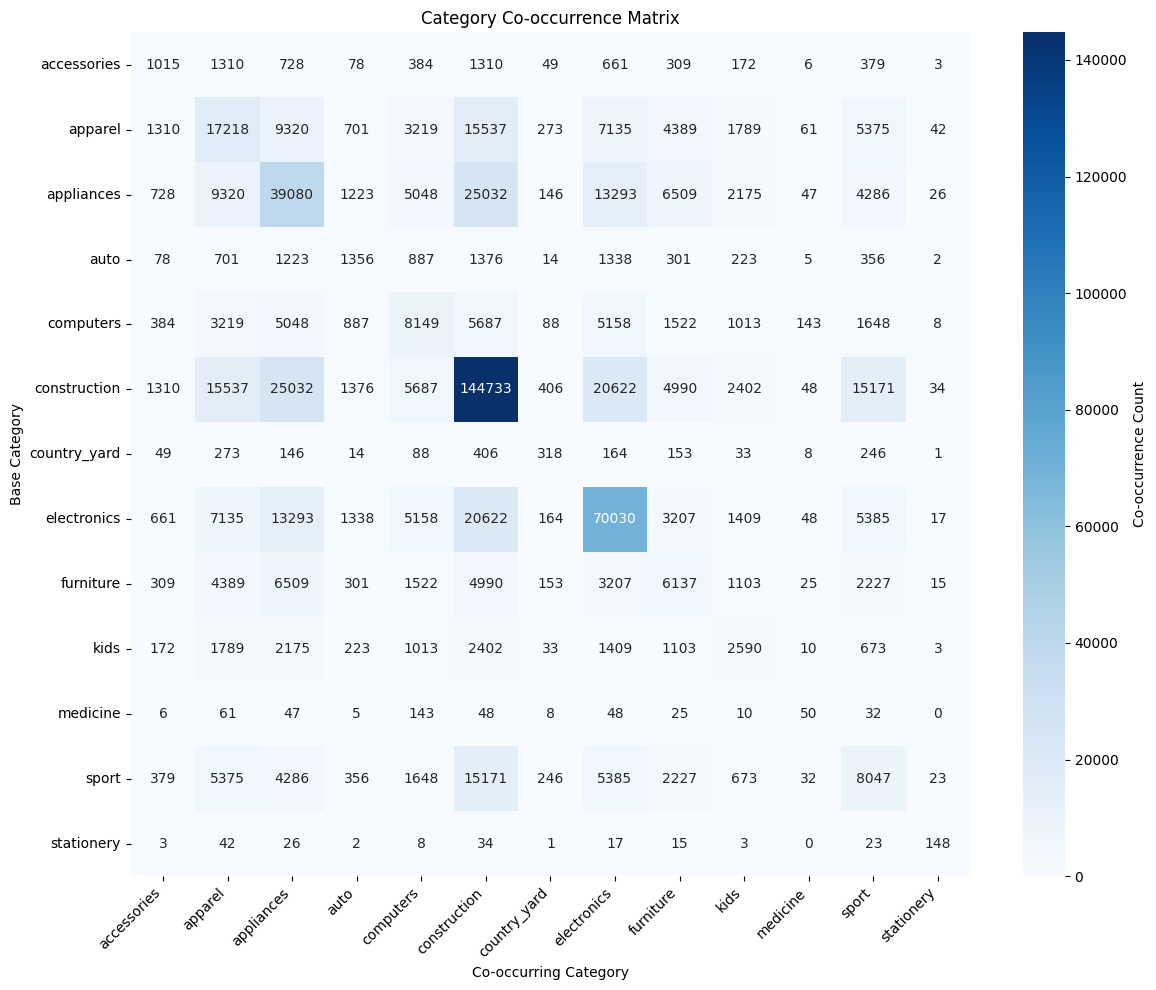

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

co_occurrence_matrix = purchase_pair_freq.pivot(
    index='base_category',
    columns='co_category',
    values='co_occurrence_count'
).fillna(0)  # fill NaNs with 0 for no co-occurrence

# Sort rows and columns alphabetically (optional)
co_occurrence_matrix = co_occurrence_matrix.sort_index(axis=0).sort_index(axis=1)

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    co_occurrence_matrix,
    annot=True,      # show counts inside the cells
    fmt='.0f',       # integer format
    cmap='Blues',    # color map
    cbar_kws={'label': 'Co-occurrence Count'}
)
plt.title('Category Co-occurrence Matrix')
plt.xlabel('Co-occurring Category')
plt.ylabel('Base Category')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

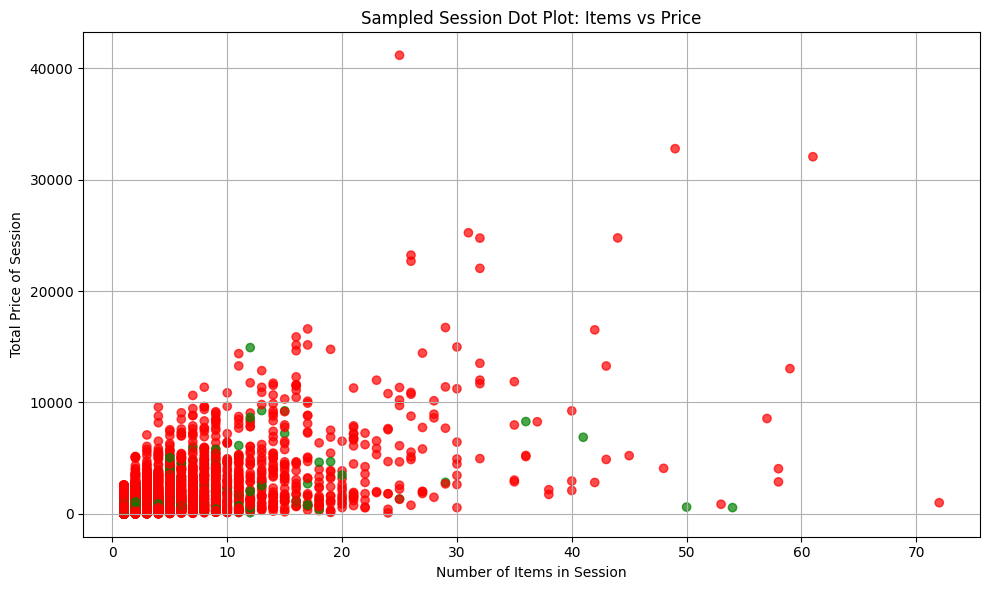

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load all session-level fields
df = con.execute("""
    SELECT user_session, price, purchased
    FROM session_summary
""").fetchdf()

# Step 2: Aggregate to session level
session_summary = (
    df.groupby('user_session')
      .agg(
          total_items=('price', 'count'),
          total_price=('price', 'sum'),
          purchased=('purchased', 'any')  # True if any item was purchased in session
      )
      .reset_index()
)

# Step 3: Sample 10,000 sessions from the aggregated session-level data
session_sample = session_summary.sample(n=10000, random_state=42) if len(session_summary) > 10000 else session_summary

# Step 4: Color mapping
colors = session_sample['purchased'].map({True: 'green', False: 'red'})

# Step 5: Dot plot
plt.figure(figsize=(10, 6))
plt.scatter(session_sample['total_items'], session_sample['total_price'], c=colors, alpha=0.7)
plt.xlabel('Number of Items in Session')
plt.ylabel('Total Price of Session')
plt.title('Sampled Session Dot Plot: Items vs Price')
plt.grid(True)
plt.tight_layout()
plt.show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/var/folders/jt/lkv1blr94z93lfzrdbq0z_7r0000gn/T/ipykernel_3051/4033052000.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_summary.groupby('price_bin')


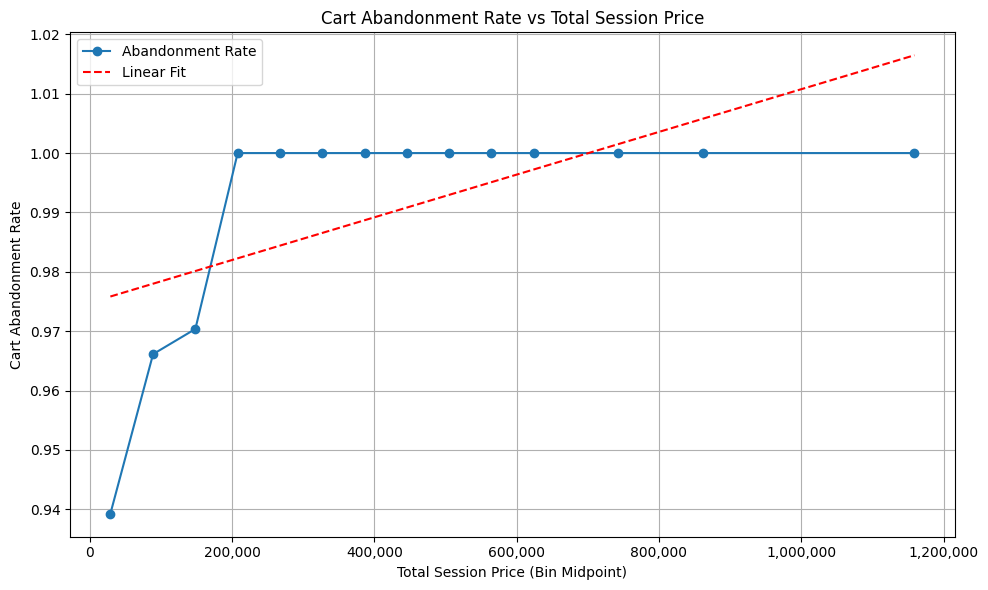

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter

# Step 1: Load required columns from the DB
df = con.execute("""
    SELECT user_session, price, purchased
    FROM session_summary
""").fetchdf()

# Step 2: Aggregate at session level
session_summary = (
    df.groupby('user_session')
      .agg(
          total_price=('price', 'sum'),
          purchased=('purchased', 'any')  # True if any item was purchased
      )
      .reset_index()
)

# Step 3: Add abandonment label
session_summary['abandoned'] = ~session_summary['purchased']

# Step 4: Bin total_price
session_summary['price_bin'] = pd.cut(session_summary['total_price'], bins=20)

# Step 5: Calculate abandonment rate per price bin
bin_stats = (
    session_summary.groupby('price_bin')
      .agg(
          abandonment_rate=('abandoned', 'mean'),
          count=('abandoned', 'size')
      )
      .reset_index()
)

# Step 6: Compute bin midpoints and drop NaNs
bin_stats['bin_mid'] = bin_stats['price_bin'].apply(lambda x: x.mid)
bin_stats = bin_stats.dropna(subset=['abandonment_rate', 'bin_mid'])

# Step 7: Plot abandonment rate vs price bin midpoint
plt.figure(figsize=(10, 6))
plt.plot(bin_stats['bin_mid'], bin_stats['abandonment_rate'], marker='o', label='Abandonment Rate')
plt.xlabel('Total Session Price (Bin Midpoint)')
plt.ylabel('Cart Abandonment Rate')
plt.title('Cart Abandonment Rate vs Total Session Price')

# Format axes to avoid scientific notation
formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))

# Step 8: Linear regression
X = bin_stats[['bin_mid']]
y = bin_stats['abandonment_rate']
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Plot regression line
plt.plot(bin_stats['bin_mid'], y_pred, color='red', linestyle='--', label='Linear Fit')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/var/folders/jt/lkv1blr94z93lfzrdbq0z_7r0000gn/T/ipykernel_3051/931528323.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_summary.groupby('price_bin')


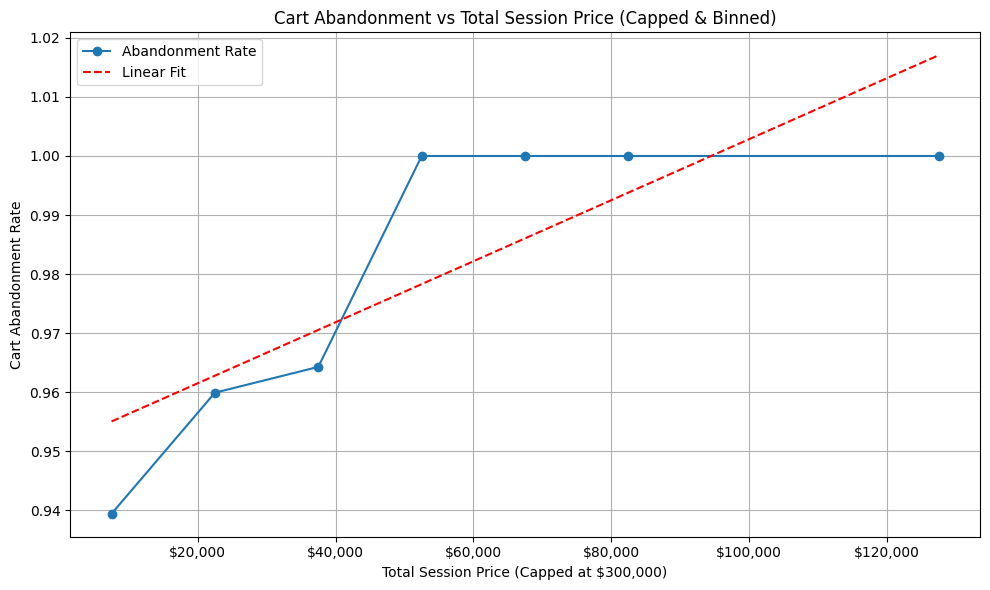

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter

# Step 1: Load necessary columns
df = con.execute("""
    SELECT user_session, price, purchased
    FROM session_summary
""").fetchdf()

# Step 2: Aggregate to session level
session_summary = (
    df.groupby('user_session')
      .agg(
          total_price=('price', 'sum'),
          purchased=('purchased', 'any')
      )
      .reset_index()
)

# Step 3: Sample max 300,000 sessions
if len(session_summary) > 300_000:
    session_summary = session_summary.sample(n=300_000, random_state=42)

# Step 4: Clip total price at $300,000
session_summary['capped_price'] = session_summary['total_price'].clip(upper=300_000)

# Step 5: Add abandonment label
session_summary['abandoned'] = ~session_summary['purchased']

# Step 6: Bin capped prices into 20 fixed-width bins from 0 to 300,000
bins = np.linspace(0, 300_000, 21)  # 20 equal-width bins
session_summary['price_bin'] = pd.cut(session_summary['capped_price'], bins=bins, include_lowest=True)

# Step 7: Compute abandonment rate and bin midpoints
bin_stats = (
    session_summary.groupby('price_bin')
      .agg(
          abandonment_rate=('abandoned', 'mean'),
          count=('abandoned', 'size')
      )
      .reset_index()
)

# Compute bin midpoints
bin_stats['bin_mid'] = bin_stats['price_bin'].apply(lambda x: x.mid)
bin_stats = bin_stats.dropna(subset=['abandonment_rate', 'bin_mid'])

# Step 8: Plot
plt.figure(figsize=(10, 6))
plt.plot(bin_stats['bin_mid'], bin_stats['abandonment_rate'], marker='o', label='Abandonment Rate')
plt.xlabel('Total Session Price (Capped at $300,000)')
plt.ylabel('Cart Abandonment Rate')
plt.title('Cart Abandonment vs Total Session Price (Capped & Binned)')

# Format axes
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))

# Step 9: Linear regression over bin midpoints
X = bin_stats[['bin_mid']]
y = bin_stats['abandonment_rate']
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

plt.plot(bin_stats['bin_mid'], y_pred, color='red', linestyle='--', label='Linear Fit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/var/folders/jt/lkv1blr94z93lfzrdbq0z_7r0000gn/T/ipykernel_3051/1333686695.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_summary.groupby('bin_mid')


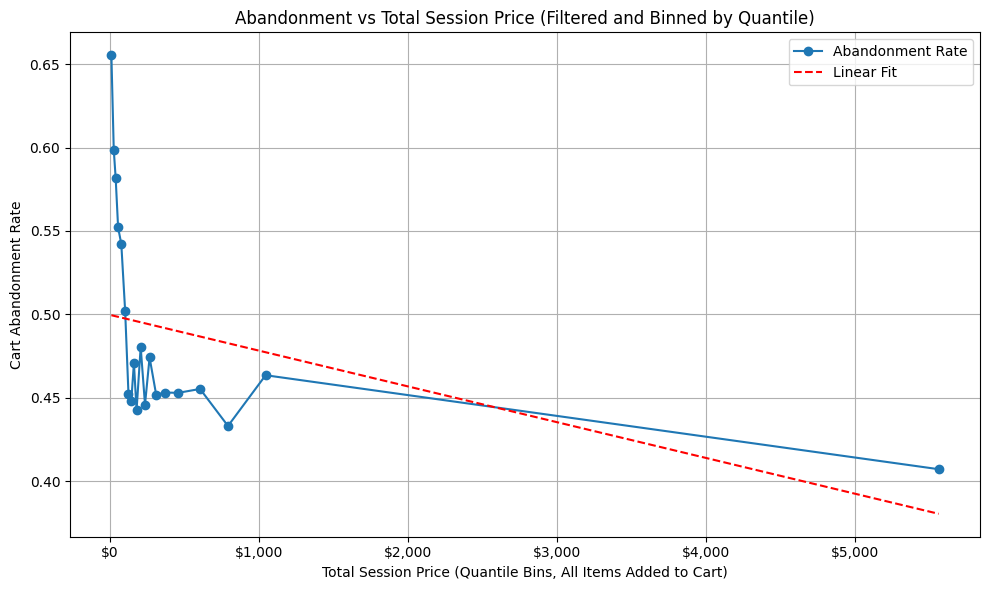

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter

# Step 1: Load relevant columns
df = con.execute("""
    SELECT user_session, price, purchased, added_to_cart
    FROM session_summary
""").fetchdf()

# Step 2: Filter to sessions where all products were added to cart
valid_sessions = (
    df.groupby('user_session')['added_to_cart']
      .all()
)

df_filtered = df[df['user_session'].isin(valid_sessions[valid_sessions].index)]

# Step 3: Aggregate to session level
session_summary = (
    df_filtered.groupby('user_session')
      .agg(
          total_price=('price', 'sum'),
          purchased=('purchased', 'any')
      )
      .reset_index()
)

# Step 4: Sample max 300,000 sessions
if len(session_summary) > 300_000:
    session_summary = session_summary.sample(n=300_000, random_state=42)

# Step 5: Add abandonment flag
session_summary['abandoned'] = ~session_summary['purchased']

# Step 6: Quantile-based binning into 20 equal-frequency bins
try:
    session_summary['price_bin'], bin_edges = pd.qcut(
        session_summary['total_price'], 
        q=20, 
        retbins=True, 
        duplicates='drop'
    )
except ValueError:
    print("Too few distinct total_price values to create 20 bins. Reducing bins.")
    session_summary['price_bin'], bin_edges = pd.qcut(
        session_summary['total_price'], 
        q=min(10, len(session_summary)), 
        retbins=True, 
        duplicates='drop'
    )

# Step 7: Compute bin midpoints
bin_mids = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]
bin_labels = dict(zip(session_summary['price_bin'].cat.categories, bin_mids))
session_summary['bin_mid'] = session_summary['price_bin'].map(bin_labels)

# Step 8: Compute abandonment rate per bin
bin_stats = (
    session_summary.groupby('bin_mid')
      .agg(
          abandonment_rate=('abandoned', 'mean'),
          count=('abandoned', 'size')
      )
      .reset_index()
)

# Step 9: Plot
plt.figure(figsize=(10, 6))
plt.plot(bin_stats['bin_mid'], bin_stats['abandonment_rate'], marker='o', label='Abandonment Rate')
plt.xlabel('Total Session Price (Quantile Bins, All Items Added to Cart)')
plt.ylabel('Cart Abandonment Rate')
plt.title('Abandonment vs Total Session Price (Filtered and Binned by Quantile)')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))

# Step 10: Linear regression
X = bin_stats[['bin_mid']]
y = bin_stats['abandonment_rate']
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

plt.plot(bin_stats['bin_mid'], y_pred, color='red', linestyle='--', label='Linear Fit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/var/folders/jt/lkv1blr94z93lfzrdbq0z_7r0000gn/T/ipykernel_3051/2002159092.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_summary.groupby('view_bin')


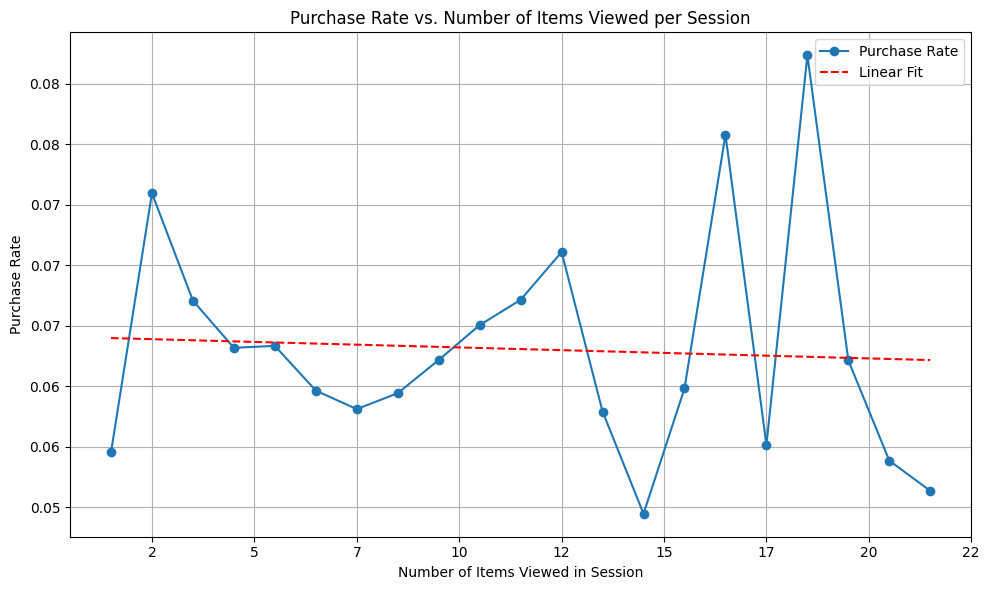

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter

# Step 1: Load relevant data
df = con.execute("""
    SELECT user_session, purchased
    FROM session_summary
""").fetchdf()

# Step 2: Aggregate sessions — count views and any purchase
session_summary = (
    df.groupby('user_session')
      .agg(
          view_count=('purchased', 'count'),
          purchased=('purchased', 'any')
      )
      .reset_index()
)

# Step 3: Sample if needed
if len(session_summary) > 300_000:
    session_summary = session_summary.sample(n=300_000, random_state=42)

# Step 4: Bin sessions by number of items viewed
# Use capped bins to avoid long tail of very large view counts
max_views = session_summary['view_count'].quantile(0.99).astype(int)
bins = np.arange(1, max_views + 2)  # 1 to max_views (inclusive), 1-item bins
session_summary = session_summary[session_summary['view_count'] <= max_views]
session_summary['view_bin'] = pd.cut(session_summary['view_count'], bins=bins, right=False)

# Step 5: Calculate purchase rate per view count bin
bin_stats = (
    session_summary.groupby('view_bin')
      .agg(
          purchase_rate=('purchased', 'mean'),
          count=('purchased', 'size')
      )
      .reset_index()
)

# Step 6: Compute bin midpoints
bin_stats['bin_mid'] = bin_stats['view_bin'].apply(lambda x: (x.left + x.right) / 2)
bin_stats = bin_stats.dropna(subset=['purchase_rate'])

# Step 7: Plot
plt.figure(figsize=(10, 6))
plt.plot(bin_stats['bin_mid'], bin_stats['purchase_rate'], marker='o', label='Purchase Rate')
plt.xlabel('Number of Items Viewed in Session')
plt.ylabel('Purchase Rate')
plt.title('Purchase Rate vs. Number of Items Viewed per Session')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))

# Step 8: Linear regression
X = bin_stats[['bin_mid']]
y = bin_stats['purchase_rate']
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

plt.plot(bin_stats['bin_mid'], y_pred, color='red', linestyle='--', label='Linear Fit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


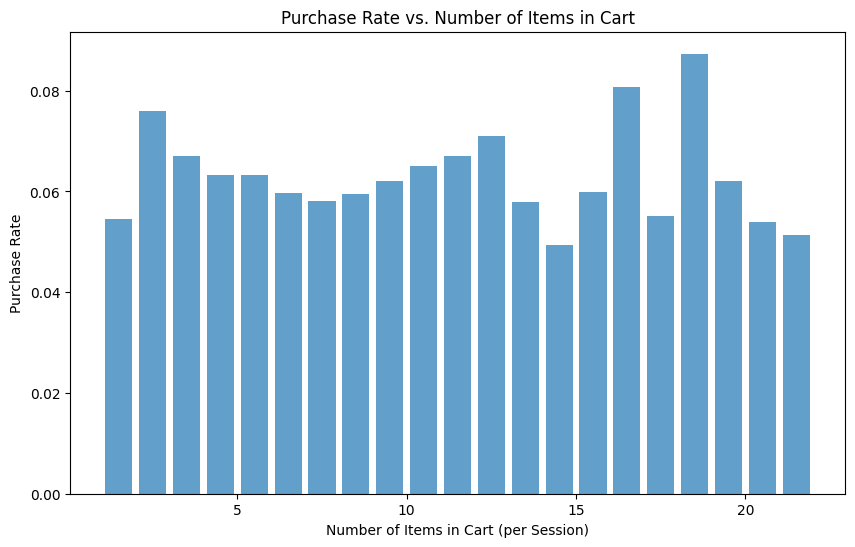

In [17]:
plt.figure(figsize=(10, 6))
plt.bar(bin_stats['bin_mid'], bin_stats['purchase_rate'], width=0.8, align='center', alpha=0.7, label='Purchase Rate')
plt.xlabel('Number of Items in Cart (per Session)')
plt.ylabel('Purchase Rate')
plt.title('Purchase Rate vs. Number of Items in Cart')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))

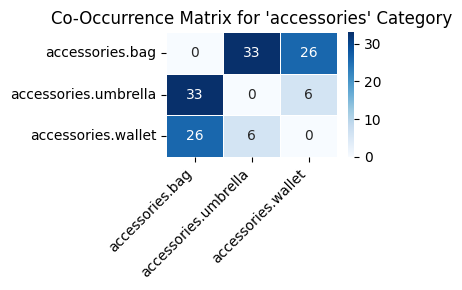

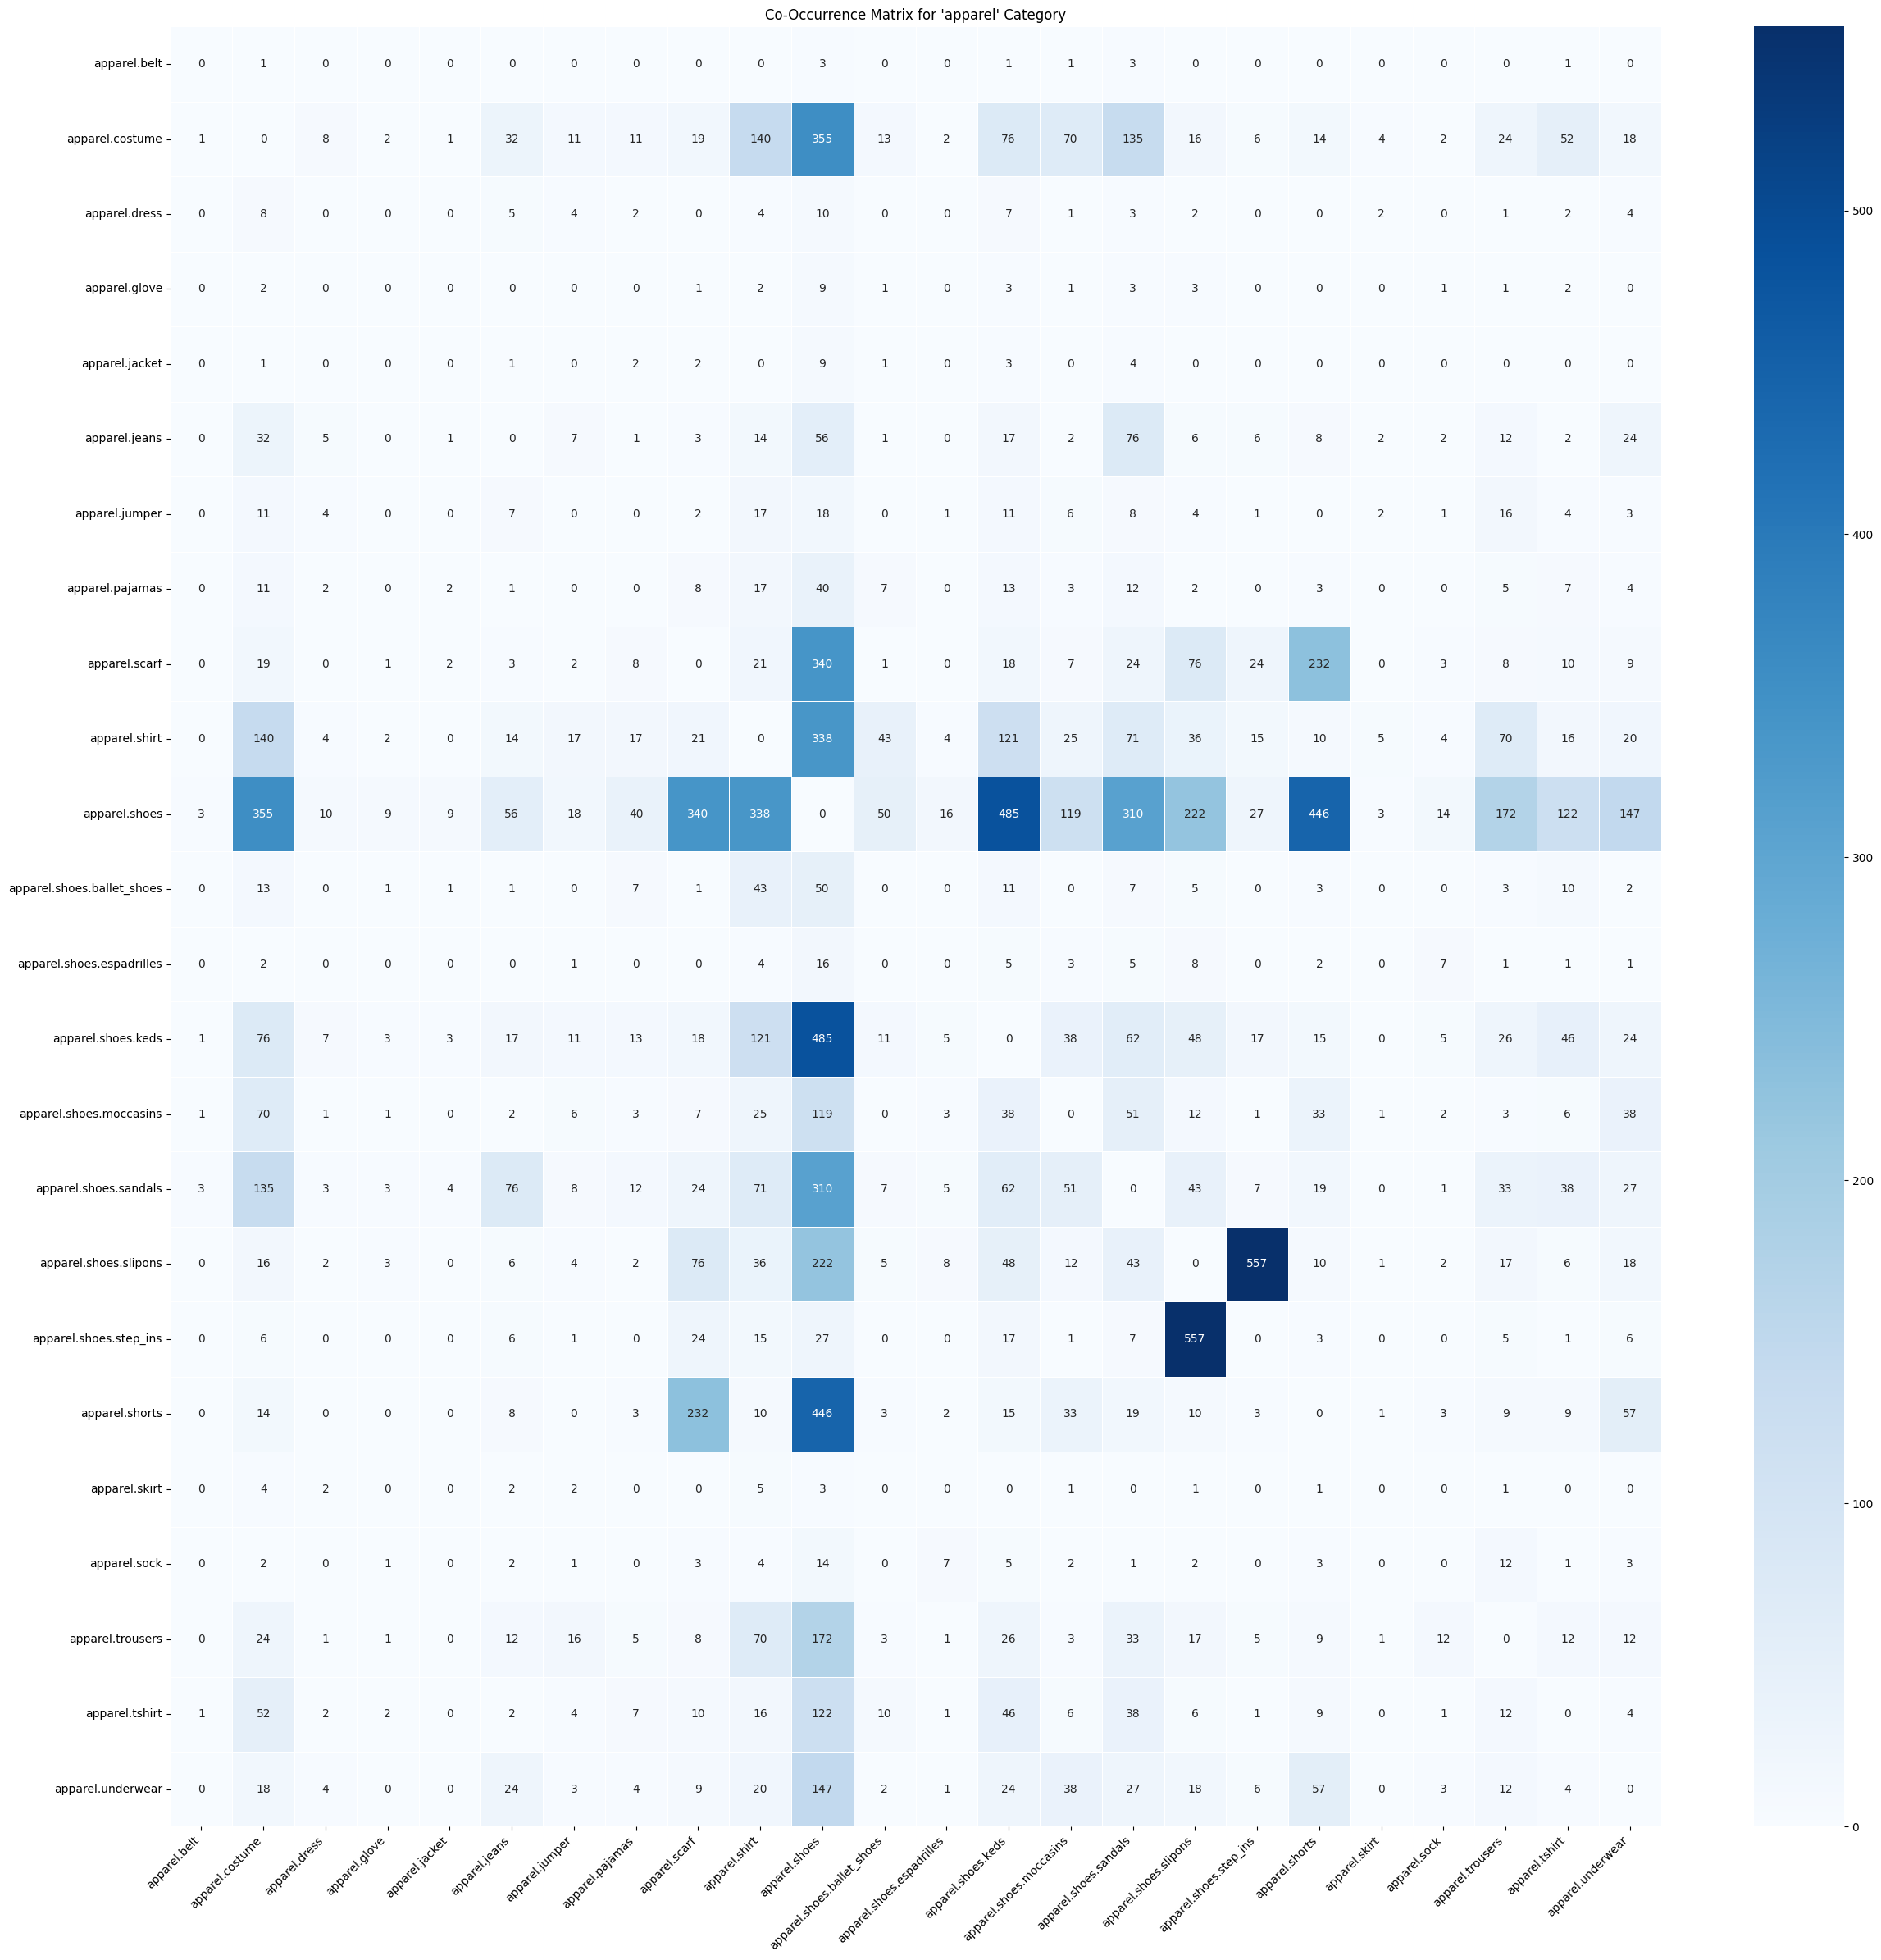

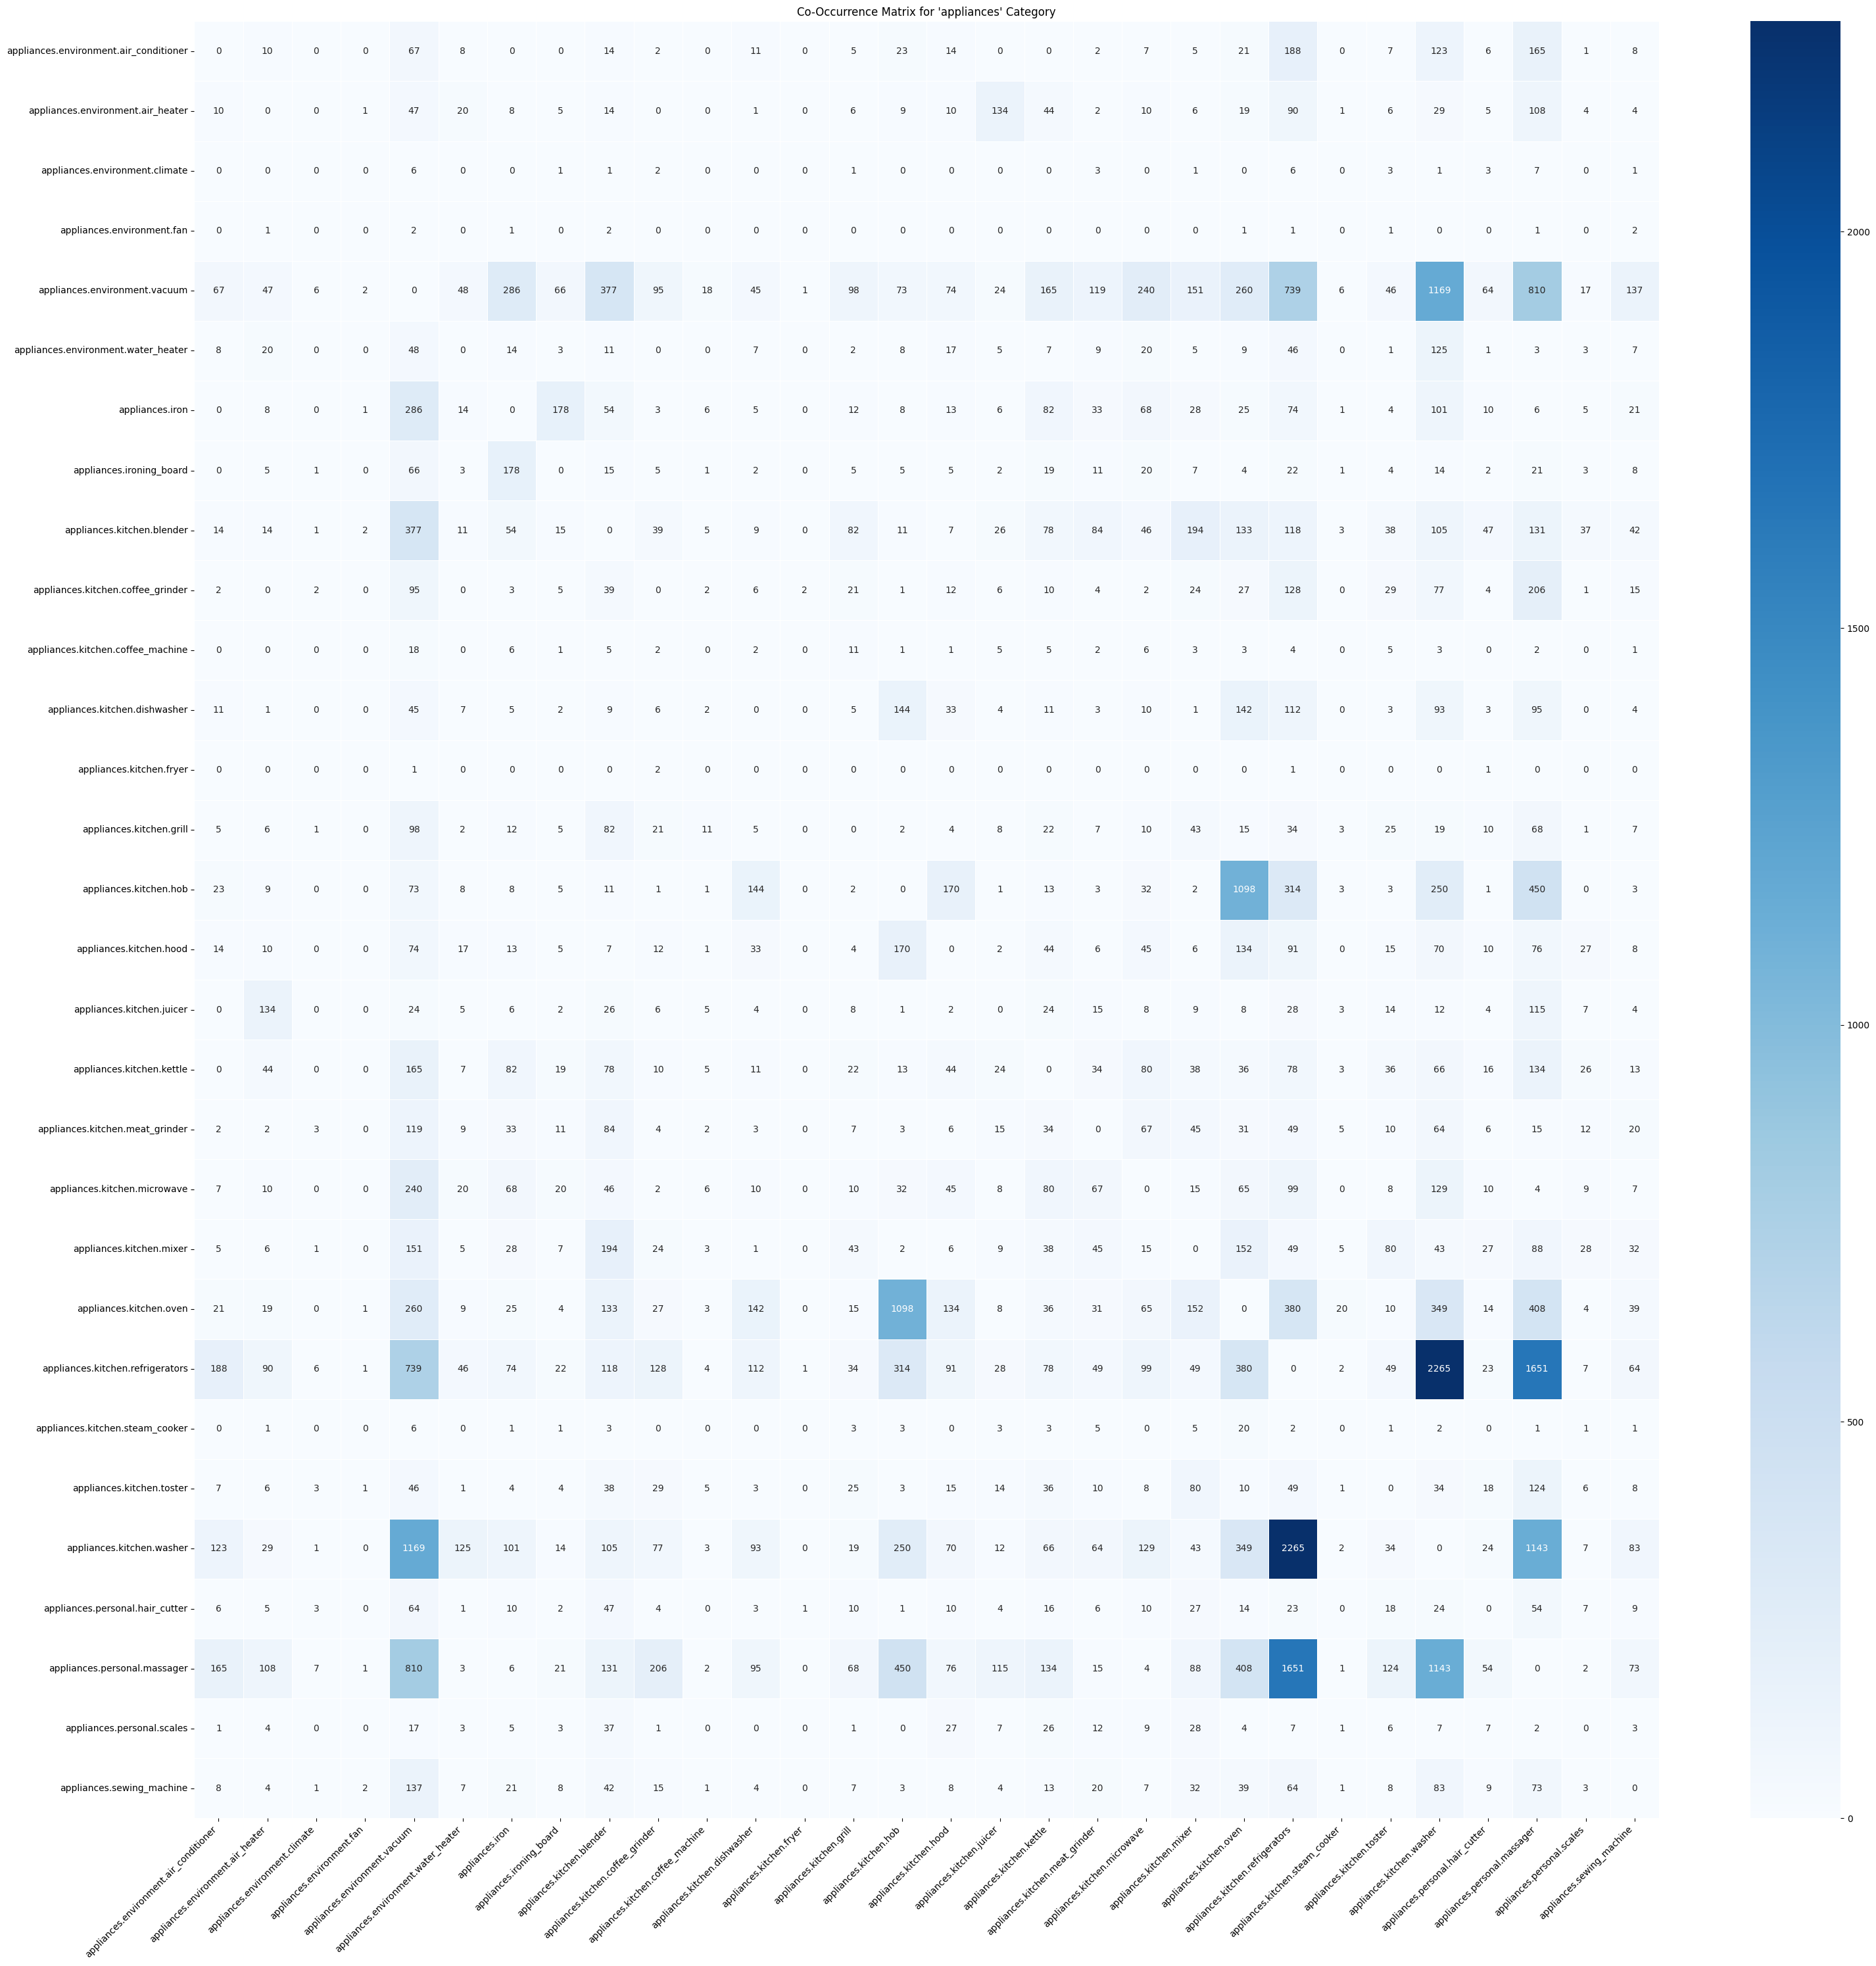

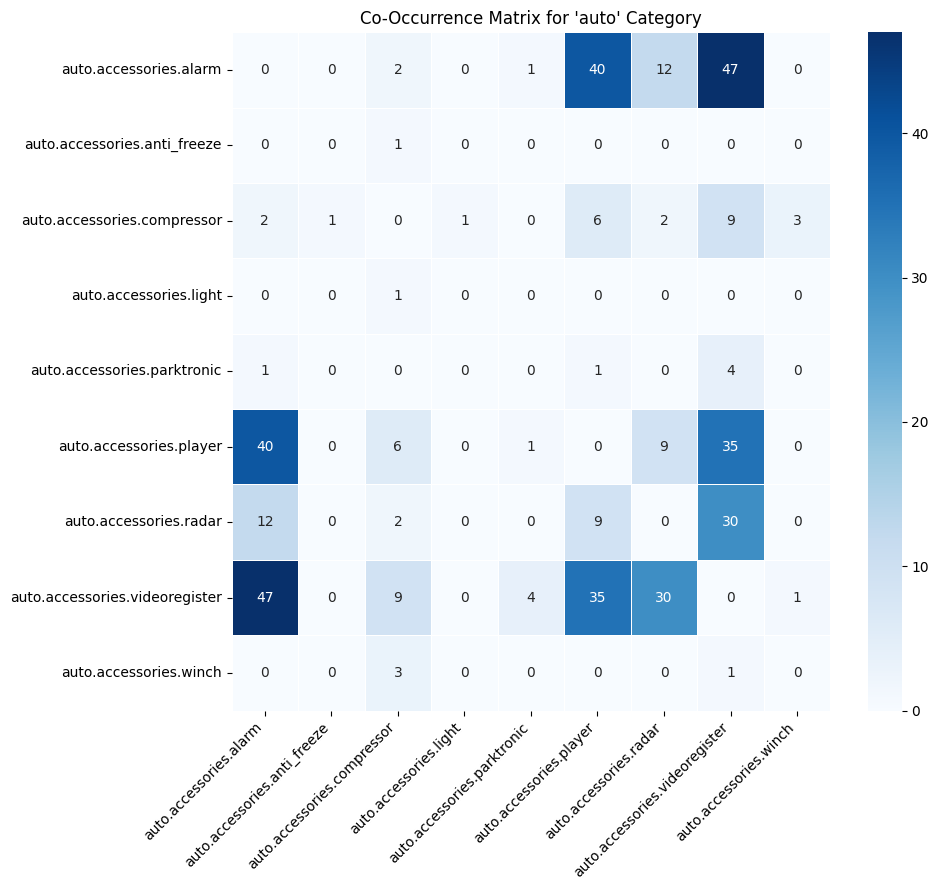

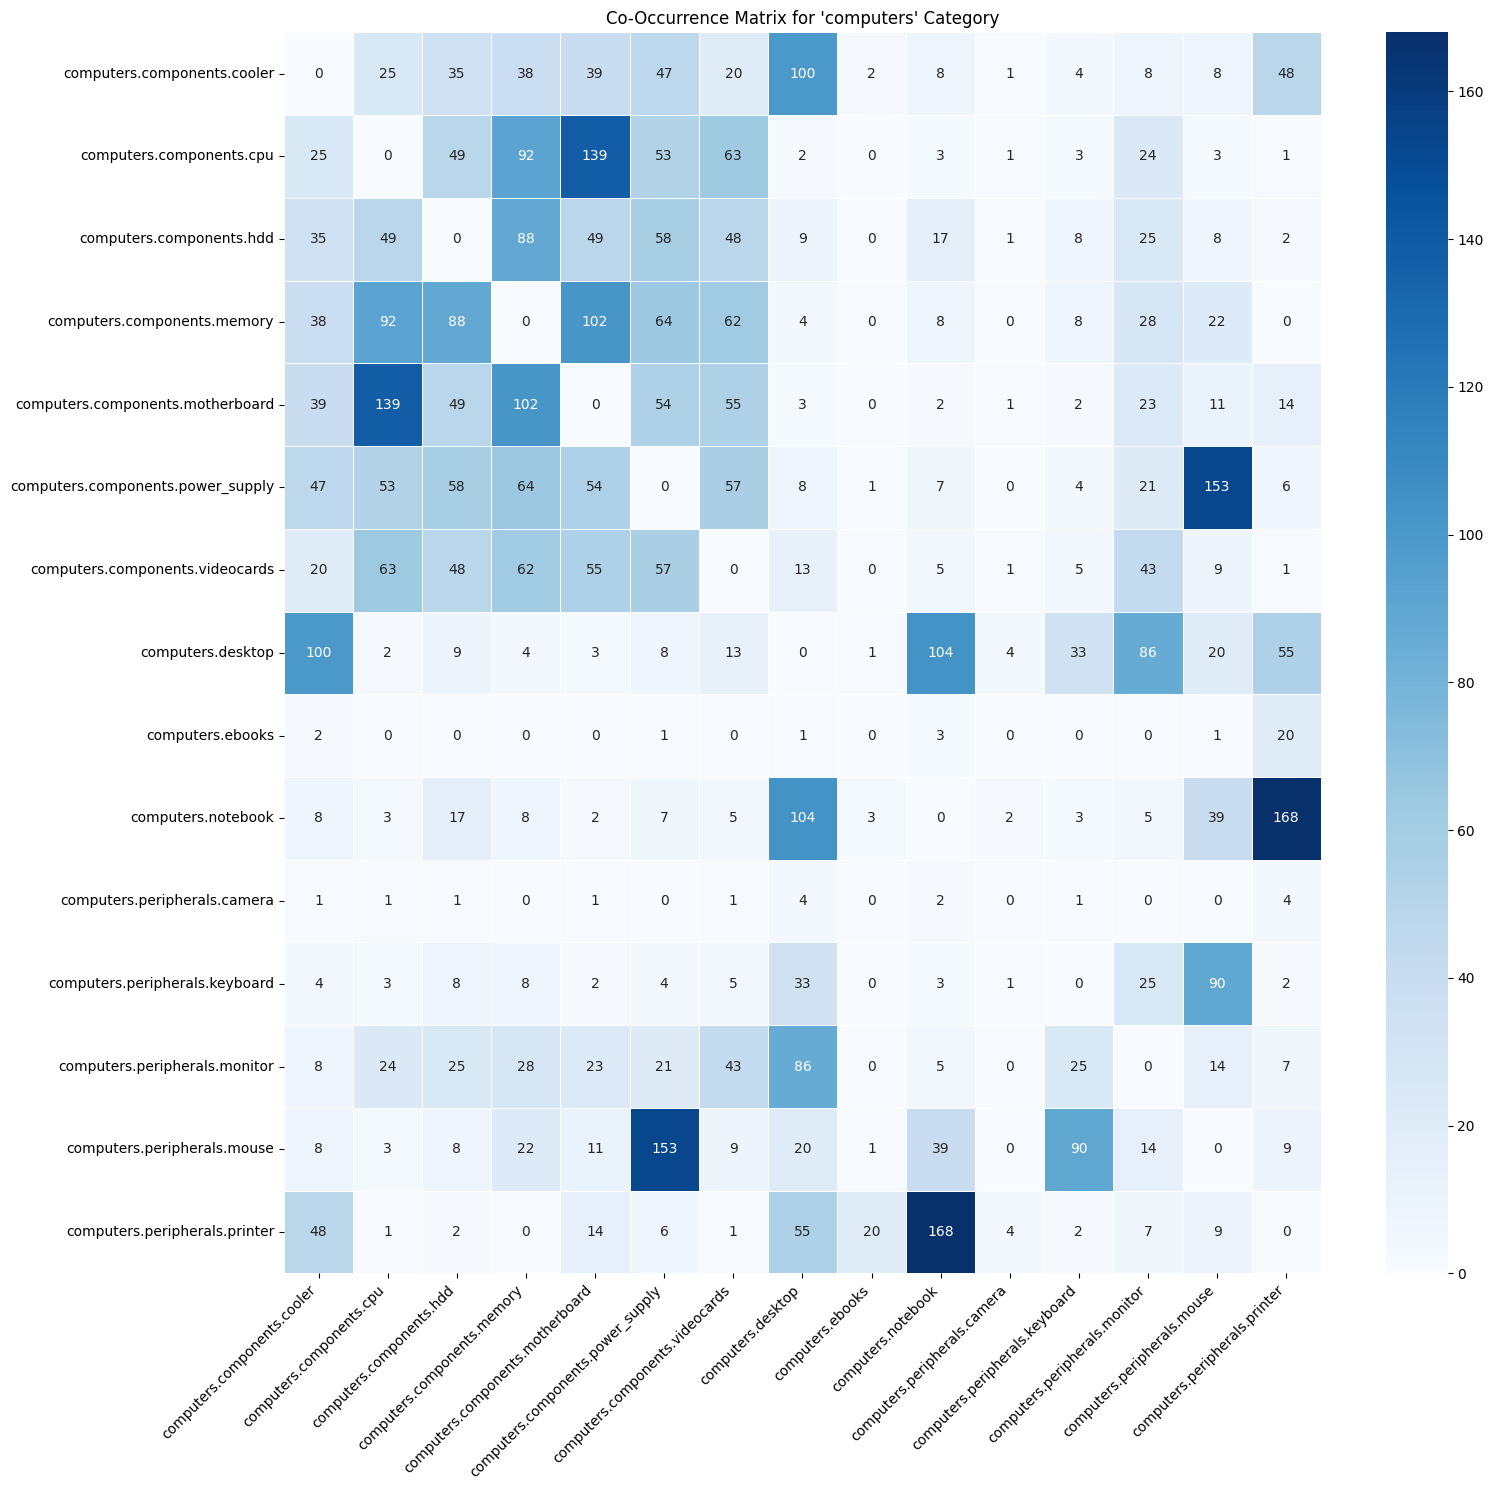

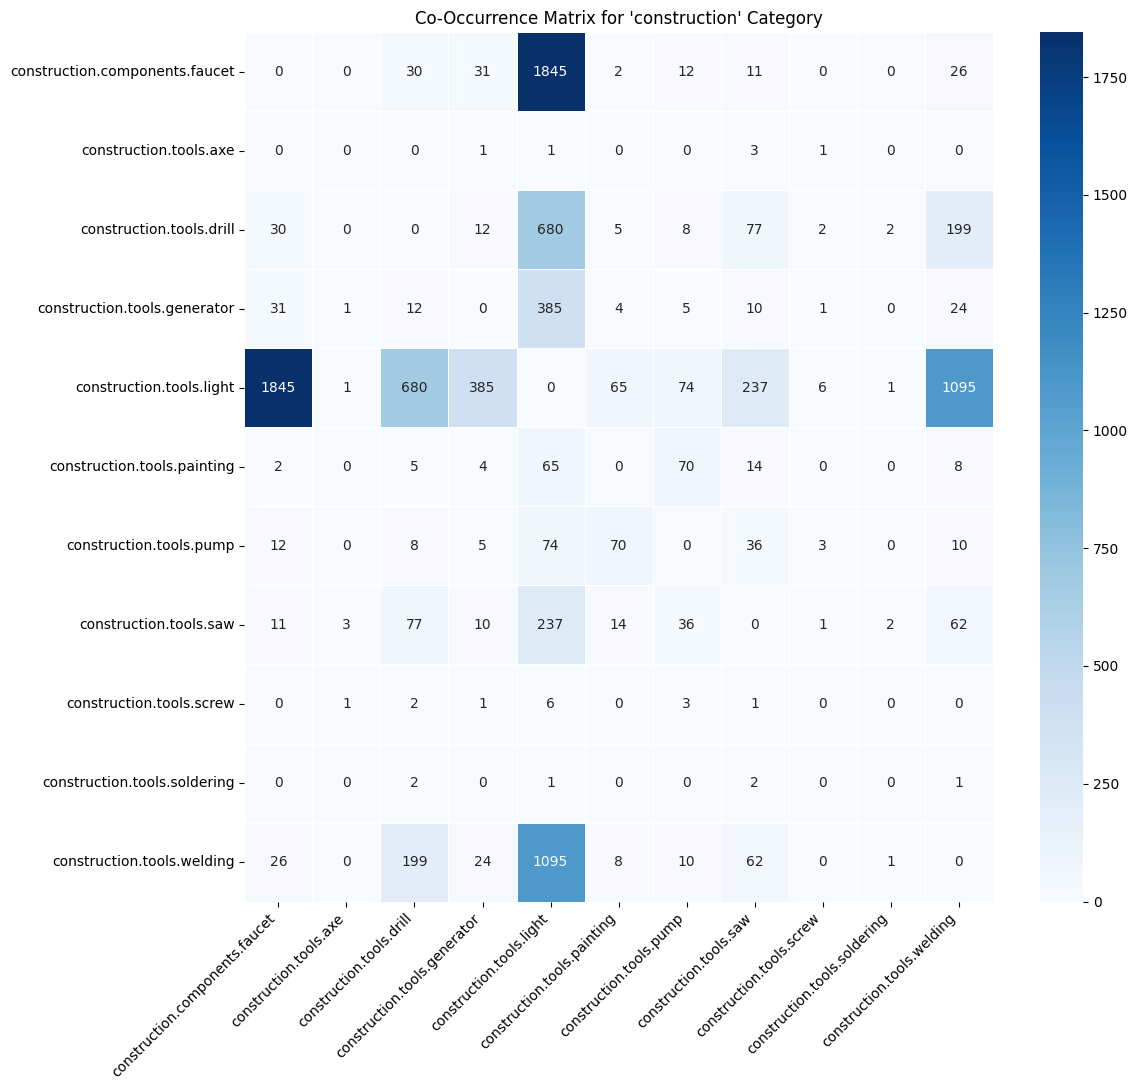

/var/folders/jt/lkv1blr94z93lfzrdbq0z_7r0000gn/T/ipykernel_3051/1166745787.py:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


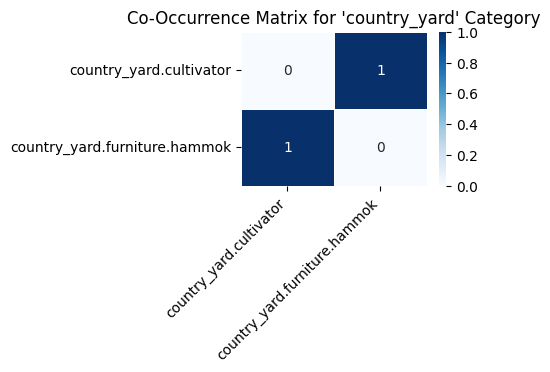

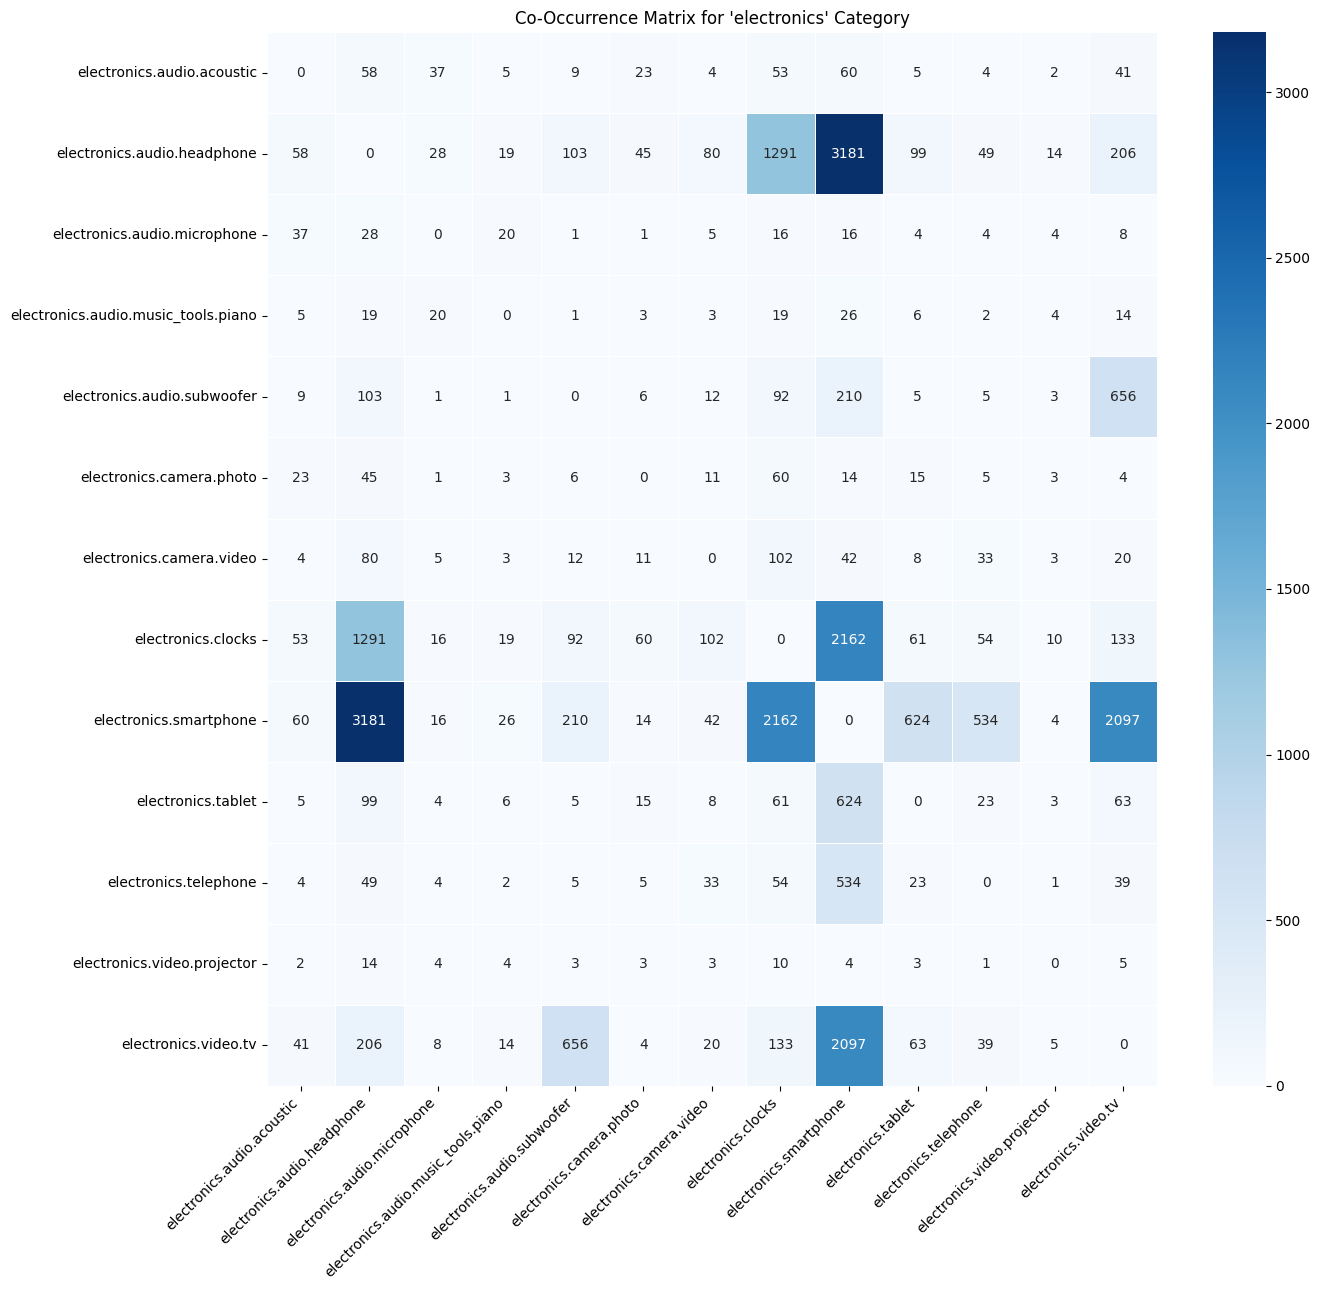

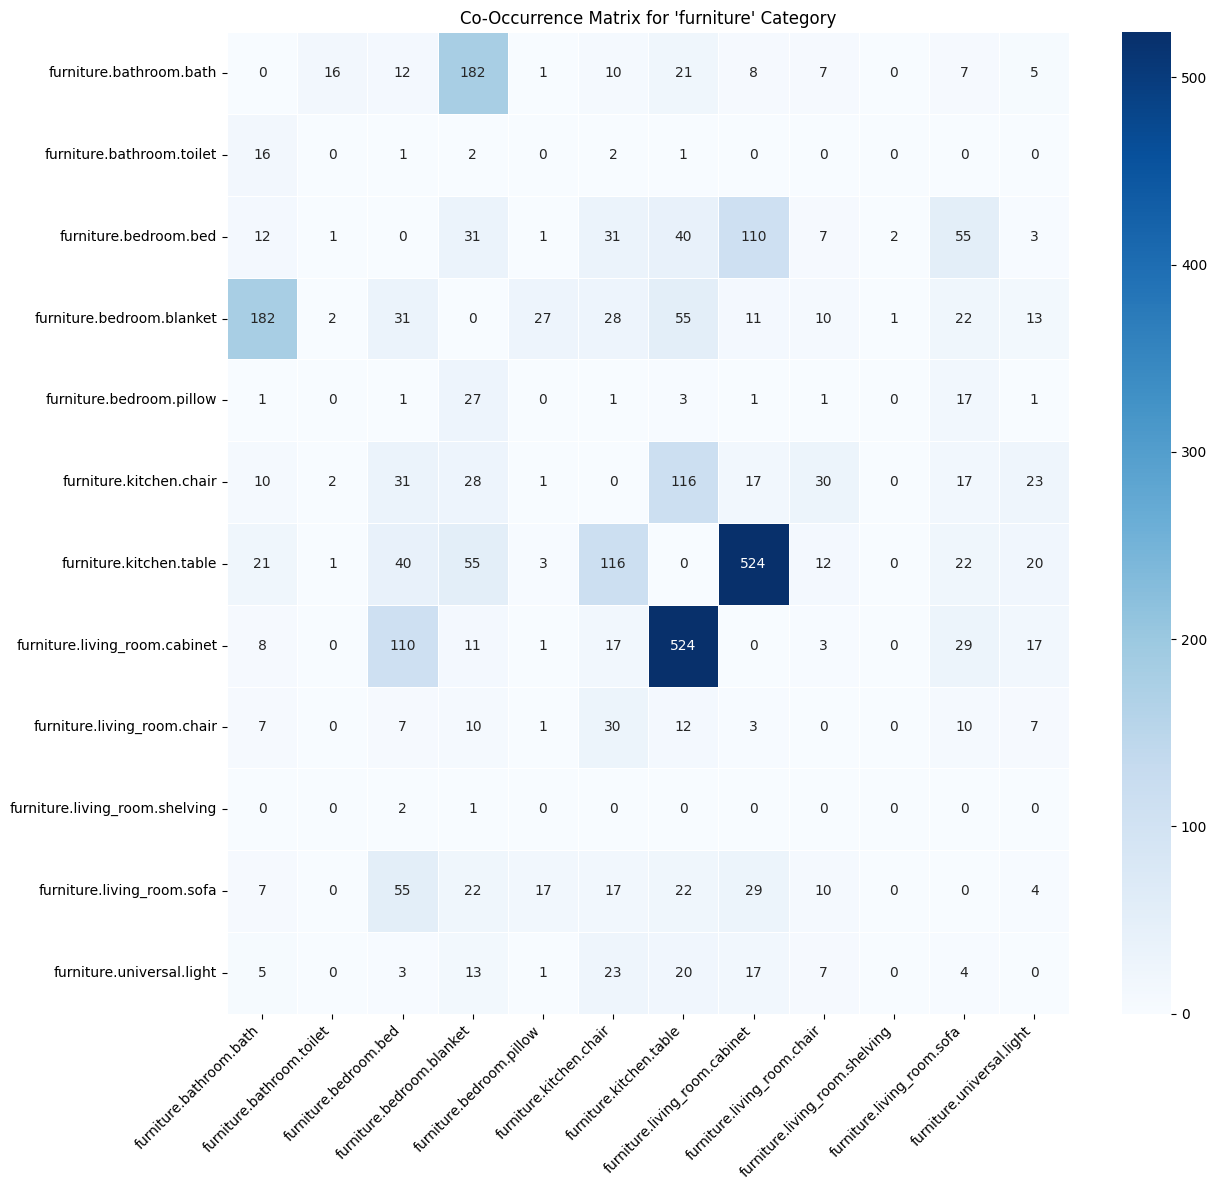

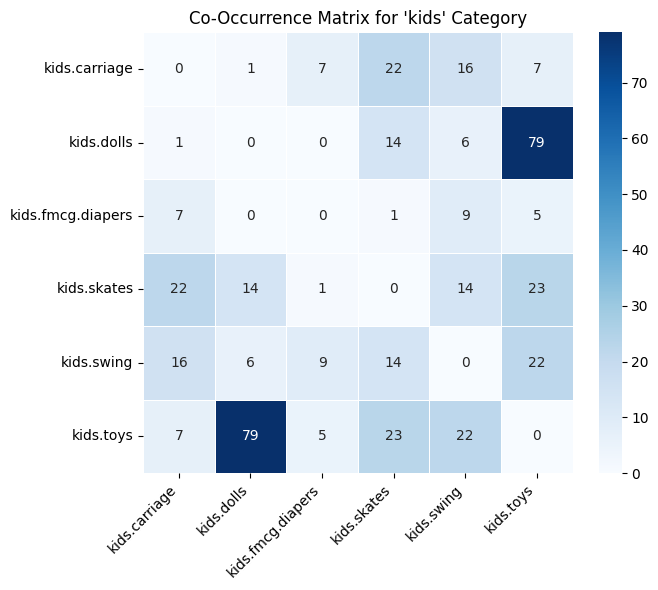

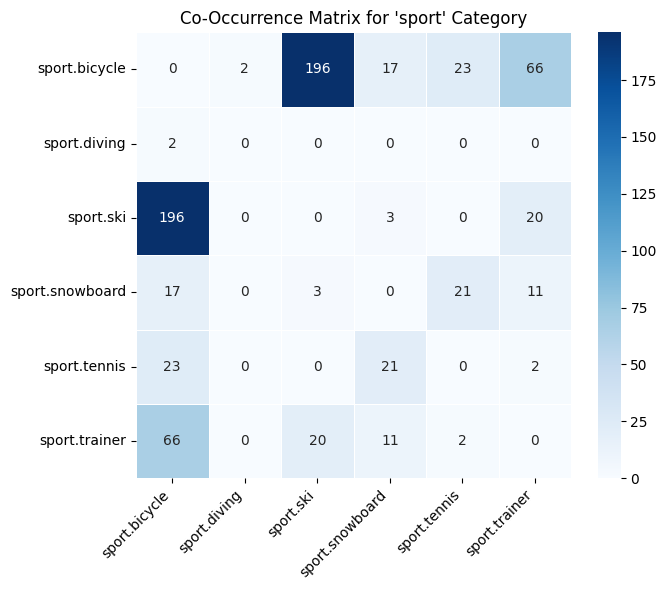

In [ ]:
# Step 1: Create a view with major category extracted
con.execute("""
    CREATE OR REPLACE VIEW purchased_with_major AS
    SELECT *,
           split_part(category_code, '.', 1) AS major_category
    FROM session_summary
    WHERE purchased = TRUE AND category_code IS NOT NULL
""")

sessions_df = con.execute("""
    SELECT user_session, major_category,
           LIST(DISTINCT category_code) AS subcategories
    FROM purchased_with_major
    GROUP BY user_session, major_category
    HAVING ARRAY_LENGTH(subcategories) > 1
""").fetch_df()

co_occurrence = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for _, row in sessions_df.iterrows():
    major = row['major_category']
    subs = row['subcategories']
    for a, b in combinations(sorted(subs), 2):
        co_occurrence[major][a][b] += 1
        co_occurrence[major][b][a] += 1

# plotz
for major in sorted(co_occurrence.keys()):
    matrix = pd.DataFrame(co_occurrence[major]).fillna(0).astype(int)
    matrix = matrix.reindex(sorted(matrix.columns), axis=0).reindex(sorted(matrix.columns), axis=1)

    if matrix.shape[0] < 2:
        continue  

    plt.figure(figsize=(matrix.shape[0]+1, matrix.shape[0]))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.title(f"Co-Occurrence Matrix for '{major}' Category")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.rc('xtick', labelsize=10)   
    plt.rc('ytick', labelsize=10)
    plt.tight_layout()
    plt.show()